# Creating regular grid

## Part 1 - Extracting a 1d grid from files

Finding the number of dimensions (D) being considered in Nicole.inp

In [ ]:
# %cd .../From-Nicole/3D/0.012 # go inside the directory that is named by the SVR cutoff 
                               # choosing SVR cutoff = 0.012 here
%cd /content/drive/MyDrive/3D_files/

def find_D(inputFile): # inputFile will take in Nicole.inp
  inputInfo = open(inputFile, 'r').readlines() # 'r' stands for read # This command will make 
                                          # a list of strings where each string is a 
                                          # particular line in inputFile
  firstline = inputInfo[0].strip() # extracts first line and removes \n
  D = firstline.split()[0] # Making a list of each element of first line
                           # and extracting the  first element of this list
  return int(D)

/content/drive/MyDrive/3D_files


In [ ]:
print("Here we are dealing with a " + str(find_D("Nicole.inp")) + " dimensional problem")

Here we are dealing with a 3 dimensional problem


For each 1D grid (labelled by indices $i_1, i_2, ...i_{N-1}$ at most) we will have to extract the $(i_1, i_2, ...i_{N-1})$ th element(s) from each of fort.$10x$, fort.$20x$, fort.$30\underline{N-1}$ files $∀ x$ 

In [ ]:
import numpy as np

def element_from_10x(xInFort10x, indices_list): # xInFort10x is the value of x in fort.10x data file (also, they are 2d arrays).
                                                # So we get the file name by doing "fort.10" + str(xInFort10x).
                                                # xInFort10x would go from 1 to D-1
                                                # indices_list contains the list of hidden indices
  if xInFort10x == 1: # fort.101 is for a 2d tensor
    i_1 = indices_list[0] # Index of the first 2d tensor
    
    element = np.loadtxt("fort.101")[:, i_1]
  else: # fort.10x is for a 3d tensor
    # The indices corresponding to this tensor will be i_(xInFort10x-1), i_(xInFort10x)
    i_xInFort10xMinus1 = indices_list[xInFort10x - 2] # -2 since indexing in a list starts with zero
    i_xInFort10x = indices_list[xInFort10x - 1] # -1 since indexing in a list starts with zero

    num = int( np.loadtxt("fort.20"+str(xInFort10x - 1)).shape[0] ) # Number of different values that i_xInFort10xMinus1 can take
    start = int (i_xInFort10xMinus1 * 
                 (np.loadtxt("fort.10" + str(xInFort10x)).shape[0]) / num )
    stop = int( (i_xInFort10xMinus1 + 1) *
               (np.loadtxt("fort.10" + str(xInFort10x)).shape[0]) / num )
    element = np.loadtxt("fort.10" + str(xInFort10x))[start:stop, i_xInFort10x]
  return element

def element_from_20x(xInFort20x, indices_list): # xInFort20x is the value of x in fort.20x data file (also, they are 1d arrays)
                                                # So we get the file name by doing "fort.20" + str(xInFort20x)
                                                # xInFort20x would go from 1 to D-1.
                                                # indices_list contains the list of hidden indices
  # We must extract the yth element from fort.20x where y = xInFort20x-th element from indices_list
  # since all fort.20x files are labelled by one index only
  y = indices_list[xInFort20x-1] # -1 since indexing in a list starts with zero
  
  element = np.loadtxt("fort.20" + str(xInFort20x))[y]
  return element

def element_from_30Dminus1(indices_list): # fort.30(D-1) is a 2d array for a 2d tensor
                                          # indices_list contains the list of hidden indices
                                          # D is the total number of dimensions being considered
  i_Nminus1 = indices_list[-1] # Index of the last 2d tensor
  
  D = find_D("Nicole.inp")
  element = np.loadtxt("fort.30" + str(D-1))[i_Nminus1, :]
  return element

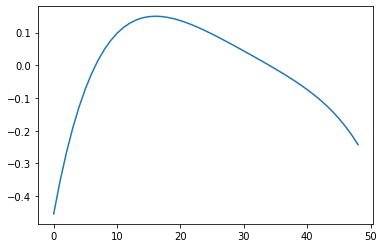

In [ ]:
import matplotlib.pyplot as plt

plt.plot(np.arange(element_from_10x(1, [2, 3]).shape[0]), element_from_10x(1, [2, 3]))
#print(element_from_20x(2, [2, 0]))
#print(element_from_30Dminus1([2,3]))

## Part 1.33 - creating a 1D grid using 1D weights

In [ ]:
import numpy as np
from sklearn.cluster import KMeans

def create_dim1_grid(dim1_weights, num_clusters_1d): # dim1_array would take in the 1d weights
                                                     # num_clusters_1d would be determined by subroutine which would have
                                                     # used the singular values tensor for this determining.
  
  len_grid = dim1_weights.shape[0] # the grid will have points, equal in number to weights, spaced by 1 unit
  unclustered_grid = np.arange(len_grid)
  unclustered_grid = np.reshape(unclustered_grid, (len_grid, 1))
  #dim1_array = np.reshape(dim1_weights, (len_grid, 1)) # don't do this since weights must be 1d array in KMeans

  kmeans_dim1 = KMeans( n_clusters=num_clusters_1d, 
                       tol=1e-12 ).fit( unclustered_grid, sample_weight=dim1_weights )
  return kmeans_dim1.cluster_centers_

In [ ]:
weights = element_from_10x(1, [2, 3]) # We will get the weights from Part 1
                                         # Now we need to determine number of clusters, which cannot be arbitrary
print(create_dim1_grid(dim1_weights=weights, num_clusters_1d=5))

[[24.09566402]
 [17.98412827]
 [12.77832884]
 [56.89650407]
 [-6.00782172]]


In [ ]:
'''using fort.801 (product singular values) to determine number of sample points for each grid.
fort.801 has a particular ordering. Then take n-th root of the element'''

'using fort.801 (product singular values) to determine number of sample points for each grid.\nfort.801 has a particular ordering. Then take n-th root of the element'

In [ ]:
# The user will give total number of points in direct product grid
num_clusters_total = 150

def findNumClusters1d(indices_list, num_clusters_total=num_clusters_total): # to find the number of cluster points in 1d array
            # Every index in first two columns of fort.801 is one more than what I have used 
            # since I have started indices from zero and they from one

  # Code for extracting product singular value from normaized fort.801 taking as input indices_list
  file_801 = np.loadtxt("fort.801")
  
  num_combinations = file_801.shape[0] # number of rows in fort.801
  D = find_D("Nicole.inp")
  for comb in range(num_combinations):
    if list(file_801[comb, 0:D-1] - 1) == indices_list: # cols 0 to D-2 will contain values of hidden variables.
                                              # There is a -1 because indices in fort.801 start from 1 whereas I start them from 0
      PSV = float(file_801[comb, -1]) # This is the product singular value
  # Using this PSV
  num_clusters_layer = PSV * num_clusters_total # Number of clusters in this particular layer
  num_clusters_1d = int(num_clusters_layer ** (1./D)) # Dth root of number of clusters in that entire layer
  return num_clusters_1d

In [ ]:
# Now I can create any 1 dimensional grid
create_dim1_grid(dim1_weights=element_from_30Dminus1([2, 0]), num_clusters_1d=findNumClusters1d([2, 0]))

array([[51.2926042 ],
       [-6.75824413],
       [14.7638235 ],
       [40.57296641]])

## Part 1.67 - Constructing a particlular layer. In case of N Dimensional sampling function, each layer is defined by N-1 parameters. eg: In case of 3D, each layer is defined by (i, j)

In [ ]:
# create a function that stacks all 1d arrays of a particular layer side-by-side
def StackLayerComponents(indices_list): # since each layer is defined by N-1 indices
  num_clusters_1d = findNumClusters1d(indices_list=indices_list) # Number of dimensions in 1d arrays
  
  D = find_D("Nicole.inp")
  All_1dGrids = np.zeros((num_clusters_1d, D)) # num_clusters_1d rows and D columns: each column is a 1d grid

  for xInFort10x in range(1, D): # fort.101 to fort.10(D-1)
    weights = element_from_10x( xInFort10x=xInFort10x, indices_list=indices_list )
    grid_1d = create_dim1_grid(dim1_weights=weights, num_clusters_1d=num_clusters_1d)
    All_1dGrids[:, xInFort10x-1] = grid_1d.flatten() # Can use .flatten() or ravel() to convert 2d array 
                                                     # to 1d (just suppressing one dimension here)

  weights = element_from_30Dminus1(indices_list)
  grid_1d = create_dim1_grid(dim1_weights=weights, num_clusters_1d=num_clusters_1d)
  All_1dGrids[:, D-1] = grid_1d.flatten() # Can use .flatten() or ravel() to convert 2d array 
                                          # to 1d (just suppressing one dimension here)
  return All_1dGrids

In [ ]:
StackLayerComponents([2, 0])[:, 2]
# (StackLayerComponents([0, 3])).shape
# using this cell you can note that all All_1d grdis have D columns 
# because each summation term in TN decomposition has D terms. 

# Also note that every 1d grid has same number of clustered points

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  


array([40.57296641, -6.75824413, 51.2926042 , 14.7638235 ])

In [ ]:
def create_layer(indices_list):
  layer_points = [] # This list will contain the final coordinates of points in the layer

  All_1dGrids = StackLayerComponents(indices_list=indices_list)
  
  # Since we want to use itertools.product, we must convert arrays to lists
  All_1dGrids_list = []
  D = find_D("Nicole.inp")
  for n in range(D): # selecting the n-th grid out of D 1d grids
    grid_1d = list( All_1dGrids[:, n] )
    All_1dGrids_list.append(grid_1d)

  from itertools import product
  for coordinate in product(*All_1dGrids_list):
    layer_points.append(coordinate)
  
  return layer_points

In [ ]:
create_layer([0, 3])

[(-18.402978310500004, 23.12303573899, 35.888223706722),
 (-18.402978310500004, 23.12303573899, 3.323443003108288),
 (-18.402978310500004, 34.53543550437, 35.888223706722),
 (-18.402978310500004, 34.53543550437, 3.323443003108288),
 (64.3296252644, 23.12303573899, 35.888223706722),
 (64.3296252644, 23.12303573899, 3.323443003108288),
 (64.3296252644, 34.53543550437, 35.888223706722),
 (64.3296252644, 34.53543550437, 3.323443003108288)]

## Part 2 - Combining all layers to get regular grid. This is where the fort.20x files will come in use, while weighting each layer with $(\text{fort.201})_{i_1} \times (\text{fort.202})_{i_2} \times..... \times (\text{fort.20}{\underline{D-1}})_{i_{D-1}}$

In [ ]:
# We will have to take weighted union of each layer over permutation of indices_list
def createRegularGrid(num_clusters_total):

  file_801 = np.loadtxt("fort.801")
  num_combinations = file_801.shape[0] # number of rows in fort.801
  D = find_D("Nicole.inp")

  regular_grid = [] # The list containing coordinates of all points in the regular grid
  for comb in range(num_combinations):
      indices_list = list(file_801[comb, 0:D-1] - 1) # cols 0 to D-2 will contain values of hidden variables.
                                                # There is a -1 because indices in fort.801 start from 1 whereas I start them from 0

      # The indices_list will have floats because list() generates float. So we must convert them to int
      for index in range(len(indices_list)):
        indices_list[index] = int(indices_list[index])
      # Now extract coordinates of points in this layer
      for coordinate_ in create_layer(indices_list=indices_list): # appending each and every point of each and every layer
        regular_grid.append(coordinate_)
  return regular_grid


In [ ]:
createRegularGrid(num_clusters_total=150)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  
/usr/local/lib/python3.7/dist-

[(56.1461868574, 8.453957696609999, 51.29260420119999),
 (56.1461868574, 8.453957696609999, 14.7638234986),
 (56.1461868574, 8.453957696609999, -6.758244128700003),
 (56.1461868574, 8.453957696609999, 40.5729664116),
 (56.1461868574, 25.6214945752497, 51.29260420119999),
 (56.1461868574, 25.6214945752497, 14.7638234986),
 (56.1461868574, 25.6214945752497, -6.758244128700003),
 (56.1461868574, 25.6214945752497, 40.5729664116),
 (56.1461868574, 37.167882453897, 51.29260420119999),
 (56.1461868574, 37.167882453897, 14.7638234986),
 (56.1461868574, 37.167882453897, -6.758244128700003),
 (56.1461868574, 37.167882453897, 40.5729664116),
 (56.1461868574, 22.493093974582, 51.29260420119999),
 (56.1461868574, 22.493093974582, 14.7638234986),
 (56.1461868574, 22.493093974582, -6.758244128700003),
 (56.1461868574, 22.493093974582, 40.5729664116),
 (-5.788765170399998, 8.453957696609999, 51.29260420119999),
 (-5.788765170399998, 8.453957696609999, 14.7638234986),
 (-5.788765170399998, 8.4539576966

In [ ]:
# Why am I getting some negative coordinates --> Because we have negative weights in fort files

# Validation scheme

In [ ]:
def sumGaussians(xInPlot1, plot2coords, sigma): # xInPlot1 is tuple containing coordinates of a point in plot 1
                                                # plot2coords are coordinates of point in second plot
                                                # sigma is standard deviation of Gaussians considered
  beta = 1./(sigma * np.sqrt(2*np.pi)) # amplitude of gaussian

  xInPlot1 = np.array(xInPlot1) # Converting the tuple into 
  sum_Gauss = 0 # variable for summing up all the Gaussian function values of x
  for x_ in plot2coords: # x_ is a tuple containing coordinates of a point in second plot
    x_ = np.array(x_)
    Gauss = beta * np.exp((xInPlot1 - x_)**2) / (2. * sigma**2)
    sum_Gauss += np.prod(Gauss)

  return sum_Gauss

In [ ]:
# Calculating the inner product and using slider

def update_result(sigma__):
  
  innerprod = 0 # This variable will store the final inner product
  normalize1 = 0 # L2 norm of sum of Gaussians for x (a point in plot1) on first graph
  normalize2 = 0 # L2 norm of sum of Gaussians for x (a point in plot1) on second graph
  sigma = sigma__ # width of Gaussian

  for n in range(len(plot1coords)): # n-th row in plot1coords  # plot1coords has not been defined earlier
    xInPlot1 = plot1coords[n] # x a point in plot1
    innerprod += ( sumGaussians(xInPlot1=xInPlot1, plot2coords=plot1coords, sigma=sigma) * 
                  sumGaussians(xInPlot1=xInPlot1, plot2coords=plot2coords, sigma=sigma) )

    normalize1 += sumGaussians(xInPlot1=xInPlot1, plot2coords=plot1coords, sigma=sigma)**2
    normalize2 += sumGaussians(xInPlot1=xInPlot1, plot2coords=plot2coords, sigma=sigma)**2

  # innerprod is unnormalized as of now
  normalize1 = np.sqrt(normalize1)
  normalize2 = np.sqrt(normalize2)
  normalize = normalize1 * normalize2 # dividing innerprod with normalize will lead to normalized innerprod

  innerprod /= normalize
  print("Inner product of both plots is " + str(innerprod))

import ipywidgets as wig
from IPython.display import display
layout = wig.Layout(width='1000px')

## DEFINE gridsize ##

sigma_ = wig.FloatSlider(description = "sigma", value = 0.1*gridsize, min = 0.01*gridsize,
                         max = 0.2*gridsize, step = 0.01, layout = layout) # relating sigma to gridsize
wig.interact(update_result, sigma__=sigma_) # Note that for very large value of sigma (which should not be taken) 
                                            # we are getting less overlap obviously

array([-6, -5, -4])